In [1]:
from pathlib import Path
from pathlib import *
import pandas as pd
import re
from random import randint
import spacy
from time import time
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim import  models
nlpd = spacy.load("da_core_news_lg")
import os

## Topic model over 00'ernes eu-debat

In [9]:
path = "../../Folketingstidende/Hele/"
dir_path = Path(f"{path}")
csv_files = list(dir_path.glob("*.csv"))

In [10]:
csv_files.sort()
csv_files[0:5]

[PosixPath('../../Folketingstidende/Hele/19531.csv'),
 PosixPath('../../Folketingstidende/Hele/19541.csv'),
 PosixPath('../../Folketingstidende/Hele/19551.csv'),
 PosixPath('../../Folketingstidende/Hele/19561.csv'),
 PosixPath('../../Folketingstidende/Hele/19562.csv')]

Jeg finder nu de filer der handler om 00'erne

In [11]:
csv_files[61:]

[PosixPath('../../Folketingstidende/Hele/20001.csv'),
 PosixPath('../../Folketingstidende/Hele/20011.csv'),
 PosixPath('../../Folketingstidende/Hele/20012.csv'),
 PosixPath('../../Folketingstidende/Hele/20021.csv'),
 PosixPath('../../Folketingstidende/Hele/20031.csv'),
 PosixPath('../../Folketingstidende/Hele/20041.csv'),
 PosixPath('../../Folketingstidende/Hele/20042.csv'),
 PosixPath('../../Folketingstidende/Hele/20051.csv'),
 PosixPath('../../Folketingstidende/Hele/20061.csv'),
 PosixPath('../../Folketingstidende/Hele/20071.csv'),
 PosixPath('../../Folketingstidende/Hele/20072.csv'),
 PosixPath('../../Folketingstidende/Hele/20081.csv')]

In [12]:
Folketingstaler_i_00erne = {}
for fil in csv_files[61:]:
    if str(fil)[-9:-5] in Folketingstaler_i_00erne:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        for tale in taler:
            Folketingstaler_i_00erne[str(fil)[-9:-5]].append(tale)
    else:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        Folketingstaler_i_00erne[str(fil)[-9:-5]] = []
        for tale in taler:
            Folketingstaler_i_00erne[str(fil)[-9:-5]].append(tale)

In [13]:
def FT_taler(indhold):
    talere = []
    tale = []
    parti = []
    Partier_i_folketinget = ["(A)", "(SF)", "(S)", "(RV)", "(KF)", "(V)", "(FP)", "(CD)", "(VS)",
                             "(KrF)", "(DR)", "(UP)", "(Grønl.)", "(Fær.)", "(DF)", "(EL)"]
    for index in range(len(indhold)):
        sentence = indhold[index]
        if len(re.findall("(^.{1,50} \([A-Z]+\)[ ]*:|^.{1,50} \(KrF\)[ ]*:|^.{1,50} \(Grønl.\)[ ]*:|^.{1,50} \(Fær.\)[ ]*:)", sentence)) > 0: #Tjekker om det er et menigt medlem
            if len(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)) < 2:    
                if len(re.findall("Ny stedf.", sentence)) > 0:
                    pass
                elif len(re.findall("Udtræder:", sentence)) > 0:
                    pass
                elif len(re.findall("Nyt medl", sentence)) > 0:
                    pass
                elif len(re.findall(" af", sentence.lower())) > 0:
                    pass
                elif re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0] in Partier_i_folketinget:
                    if len(sentence) <= 35:
                        talere.append(sentence)
                        parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
                        tale.append("")
                    else: #Tager højde for læsefejl!
                        lang_taler = re.split("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)
                        talere.append(lang_taler[-2])
                        parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", lang_taler[-2])[0])
                        tale.append(lang_taler[-1])
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else: #ellers er det en tale
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
                #if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
        elif len(re.findall("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)) > 0 and re.match("^Af ", sentence):
            talere.append(sentence)
            parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
            tale.append("")
        elif len(re.findall("(^.{1,50} \([A-Z]+\):|.{1,50} \(KrF\):)", sentence)) > 0:
            if len(sentence) > 35:
                if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
                    if len(re.findall("Ny stedf.", sentence)) > 0:
                        pass
                    elif len(re.findall("Udtræder:", sentence)) > 0:
                        pass
                    elif len(re.findall("Nyt medl", sentence)) > 0:
                        pass
                    elif len(re.findall(" af", sentence.lower())) > 0:
                        pass
                    elif re.findall("(\([A-Z]+\)|\(KrF\))", sentence)[0] in Partier_i_folketinget:
                        problem_menigt = re.split("(^.{1,50} \([A-Z]+\):|.{1,50} \(KrF\):)", sentence.lower())
                        talere.append(problem_menigt[-2])
                        parti.append("problem")
                        tale.append(problem_menigt[-1])
                    else:
                        if len(tale) >= 1:
                            tale[-1] = tale[-1] + " " + sentence
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif sentence.lower() == "formanden" or sentence.lower() == "formanden:": #tjekker om det er formanden der taler
            talere.append("formanden")
            parti.append("Formanden")
            tale.append("")
        elif re.search("næstformand \(\w*\):$", sentence.lower()) or re.search("næstformand \(\w* \w*\):$", sentence.lower()):
            talere.append(sentence.lower())
            parti.append("næstformanden")
            tale.append("")
        elif len(sentence) < 100: #Tjekker om det er en minister der taler
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\)", sentence.lower())) > 0:
                talere.append(sentence)
                parti.append("Regeringen")
                tale.append("")
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(sentence) >= 100:
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\):", sentence.lower())) > 0:
                tale_med_minister = re.split("\w*minister[\w ]*\(([\w-]*|[\w ]*)\):", sentence.lower())
                talere.append(tale_med_minister[-2])
                parti.append("Regeringen")
                tale.append(tale_med_minister[-1])
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("[1-9]{1,5} [1-9]{1,2}/[1-9]{1,2}", sentence.lower()))  > 0: #tilføjet til at fange headers på sider
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("^[1-9]{1,2}/[1-9]{1,2}", sentence.lower())) > 0: 
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif re.fullmatch("\[.{1,100}\]", sentence.lower()):
            pass
        elif re.fullmatch("[1-9]{1,10}", sentence.lower()):
            pass
        else:
            if len(tale) >= 1:
                tale[-1] = tale[-1] + " " + sentence
    return tale, talere, parti

In [14]:
Folketingsår_opdelt_per_taler_00erne = {}
problemer = {}
for år in Folketingstaler_i_00erne:
    indhold = Folketingstaler_i_00erne[år]
    år_tale, år_talere, år_parti = FT_taler(indhold)
    Folketingsår_opdelt_per_taler_00erne[år] = []
    Folketingsår_opdelt_per_taler_00erne[år].append(år_tale)
    Folketingsår_opdelt_per_taler_00erne[år].append(år_talere)
    Folketingsår_opdelt_per_taler_00erne[år].append(år_parti)

## Lissabon og Nice i tekst

Jeg starter med Nice-traktaten

In [15]:
eu_ord_2 = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarkedet", "ømu", " eu-", " ef-"]
nice_taler = []
nice_taler_ikke_eu = []
for år in Folketingsår_opdelt_per_taler_00erne:
    for sentence in Folketingsår_opdelt_per_taler_00erne[år][0]:
        if len(re.findall("nice", sentence.lower())) > 0:
            total = 0
            for ord_type in eu_ord_2:
                total += len(re.findall(ord_type, sentence.lower()))
            if total == 0:
                nice_taler_ikke_eu.append(sentence.lower())
            else:        
                nice_taler.append((år, sentence.lower()))

In [16]:
len(nice_taler_ikke_eu)

365

Der er altsp 118 folketingstaler hvor "Nice" indgår uden de ovenstående ord.

Jeg fjerner nu dem der også handler om traktater.

In [17]:
nice_taler_ikke_eu_ikke_traktat = []
for sentence in nice_taler_ikke_eu:
    if len(re.findall("nicetraktat", sentence.lower())) > 0 or len(re.findall("traktat", sentence.lower())) > 0:
        pass
    else:
        nice_taler_ikke_eu_ikke_traktat.append(sentence)

In [18]:
len(nice_taler_ikke_eu_ikke_traktat)

98

In [19]:
nice_taler_ikke_eu_ikke_traktat

[' jeg er ikke overrasket, men må konstatere, at dansk folkeparti altid kun hører, hvad de vil høre. og jeg vil anbefale, at de fremover lytter efter. jeg skal gerne gentage, hvad jeg sagde i min tale: dialog skal være omdrejningspunktet, når 62 torsdag den 5. oktober 2000 (r 1) der skal findes løsninger i demokratiet. det, vi var vidner til i københavns gader i går, var derfor helt uacceptabelt. det, jeg siger, er, at vi lever i et demokrati. det bygger på dialog og ikke på bøller. det er helt uacceptabelt, lige meget hvem det er, der laver sådan noget ballade. om det er fodboldbøller, om det er rockere, eller om det er palæstinensere, så vil vi ikke acceptere det. vi vil ikke finde os i det. det var det, jeg sagde. og jeg kan ikke forstå, at hr. kristian thulesen dahl overhovedet kunne misforstå det. men o.k., det må jeg jo så tage til efterretning. angående folkeafstemningen i torsdags så synes jeg, at modstanderne, i hvert fald dansk folkeparti, skal passe på, at de ikke tager pate

In [20]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning = []
for sentence in nice_taler_ikke_eu_ikke_traktat:
    if len(re.findall("folkeafstemning", sentence.lower())) > 0:
        pass
    else:
        nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning.append(sentence)

In [21]:
len(nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning)

88

In [22]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning

[' debatten her af forslaget til vedtagelse og det møde, der er indkaldt til i næste uge, skal faktisk opfattes som en udstrakt hånd til at tage en debat. der står jo netop i vedtagelsen, at der skal holdes tæt kontakt med folketingets partier og europaudvalget, og der skal også drøftes et lidt længere perspektiv, altså: hvad skal der ske efter nice med hensyn til samarbejdet mellem medlemslandene og europas globale indsats? jeg synes faktisk, det er ret flot og overordnet. vores holdning ligger fast. vi vil ikke medvirke til ting, der direkte eller indirekte påvirker vores velfærdspolitik eller vores arbejdsmarkedsmodel. det er socialdemokratiets holdning. det har vi sådan set ment hele tiden. det er det, vi hele tiden har sagt. vi vil ikke medvirke til noget, der på nogen måde kan bringe dansk velfærd i fare. det synes jeg bør være rimelig klart, både efter debatten her og også efter det, der står i forslaget til vedtagelse. (kort bemærkning).',
 ' jeg synes, det er tydeligt at høre,

In [23]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde = []
for sentence in nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning:
    if len(re.findall("nicetopmøde", sentence.lower())) > 0 or len(re.findall("topmøde", sentence.lower())) > 0:
        pass
    else:
        nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde.append(sentence)

In [24]:
len(nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde)

78

In [25]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde

[' debatten her af forslaget til vedtagelse og det møde, der er indkaldt til i næste uge, skal faktisk opfattes som en udstrakt hånd til at tage en debat. der står jo netop i vedtagelsen, at der skal holdes tæt kontakt med folketingets partier og europaudvalget, og der skal også drøftes et lidt længere perspektiv, altså: hvad skal der ske efter nice med hensyn til samarbejdet mellem medlemslandene og europas globale indsats? jeg synes faktisk, det er ret flot og overordnet. vores holdning ligger fast. vi vil ikke medvirke til ting, der direkte eller indirekte påvirker vores velfærdspolitik eller vores arbejdsmarkedsmodel. det er socialdemokratiets holdning. det har vi sådan set ment hele tiden. det er det, vi hele tiden har sagt. vi vil ikke medvirke til noget, der på nogen måde kan bringe dansk velfærd i fare. det synes jeg bør være rimelig klart, både efter debatten her og også efter det, der står i forslaget til vedtagelse. (kort bemærkning).',
 ' jeg synes, det er tydeligt at høre,

Det eneste problem er nice og unicef.

Nu finder jeg lissabon:

In [26]:
eu_ord_2 = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarkedet", "ømu", " eu-", " ef-"]
lissabon_taler = []
lissabon_taler_ikke_eu = []
for år in Folketingsår_opdelt_per_taler_00erne:
    for sentence in Folketingsår_opdelt_per_taler_00erne[år][0]:
        if len(re.findall("lissabon", sentence.lower())) > 0:
            total = 0
            for ord_type in eu_ord_2:
                total += len(re.findall(ord_type, sentence.lower()))
            if total == 0:
                lissabon_taler_ikke_eu.append(sentence.lower())
            else:        
                lissabon_taler.append((år, sentence.lower()))

In [27]:
len(lissabon_taler_ikke_eu)

276

In [28]:
lissabon_taler_ikke_eu

[' jf. den nuværende art. 137, stk. 2 sidste afsnit kan rådet vedtage foranstaltninger til fremme af samarbejdet mellem medlemslandene, gennem initiativer, der tager sigte på at opnå større viden, udvikle udvekslingen af information og gode erfaringer, fremme nytænkning og vurdere erfaringer, med det formål at bekæmpe social udstødelse. fsva. sidstnævnte er der følgelig ikke tale om nogen ny tilføjelse. det foreslås - jf. confer 4795 af 9. november 2000 - at der i samme bestemmelse skabes mulighed for fremme af samarbejdet mellem medlemsstater fsva. »udvikling og forbedring af social beskyttelse«. det præciseres, at denne bestemmelse ikke indebærer harmonisering af medlemsstaternes love og administrative bestemmelser. forslaget ligger i direkte forlængelse af det europæiske råds møde i lissabon i marts, hvor man besluttede at styrke den åbne koordinati- onsmetode, hvorefter samarbejde vedrørende social beskyttelse primært bygger på erfaringsudveksling og samarbejde mellem medlemslanden

Lissabon virker til at være om lissabontraktaten.

## EVT Frankfurt

In [205]:
eu_ord_2 = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarkedet", "ømu", " eu-", " ef-"]
frankfurt_taler = []
frankfurt_taler_ikke_eu = []
for år in Folketingsår_opdelt_per_taler_00erne:
    for sentence in Folketingsår_opdelt_per_taler_00erne[år][0]:
        if len(re.findall("frankfurt", sentence.lower())) > 0:
            total = 0
            for ord_type in eu_ord_2:
                total += len(re.findall(ord_type, sentence.lower()))
            if total == 0:
                frankfurt_taler_ikke_eu.append(sentence.lower())
            else:        
                frankfurt_taler.append((år, sentence.lower()))

In [206]:
len(frankfurt_taler_ikke_eu)

17

In [207]:
frankfurt_taler_ikke_eu

[' hr. kim behnke som ordfører. kim behnke (fri): som deltager i en finanslovdebat igennem mange år må jeg sige, at det har været en fornøjelse at lytte til debatten i år. mest fordi et emne, der i mange år nærmest har været tabu i forhold til finanslovdebatterne, skattespørgsmålet, endelig har fået den plads, hvor det hører hjemme, nemlig i forbindelse med finansloven. regeringen har det ikke dumme synspunkt, faktisk rimelig velargumenteret, at de skatteindtægter, der kommer i øjeblikket, primært skal gå til at afdrage på gælden. kigger vi på de mange klodser, en finanslov er sammensat af, ja, så er det jo også ubehageligt at konstatere, at lige præcis forrentningen af statens gæld er en af de allerstørste klodser, vi har på finansloven. så der er kun gode argumenter for at få bragt statens gæld ned. det kan jo ikke undgås, at man kommer til at tænke tilbage på de mange gange, hvor jeg fra denne talerstol har advaret imod, at man vedtog finanslove med underskud og de gange var med til

### Nu udvælges folketingstaler

In [208]:
EU_ord = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarked", "ømu", "maastricht", 
          "amsterdamtraktaten", "eu-", "ef-", "edinburgh", "indre marked", "lissabon", "euro-", "euro "] + [" eu\.", " euro ", "euroen", " ef\.", " eu\,", " ef\,"]

In [209]:
eu_taler_00erne = {}
for år in Folketingsår_opdelt_per_taler_00erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_00erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_00erne[år][0][index]
        for ord_ in EU_ord:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_parti_år.append(Folketingsår_opdelt_per_taler_00erne[år][1][index])
                eu_taler_år.append(Folketingsår_opdelt_per_taler_00erne[år][2][index])
                break
        if len(eu_tale_år) != 0:
            if eu_tale_år[-1] != tale:
                if len(re.findall("nice", tale.lower())) > 0:
                    if len(re.findall("unicef", tale.lower())) == 0:
                        eu_tale_år.append(tale)
                        eu_parti_år.append(Folketingsår_opdelt_per_taler_00erne[år][1][index])
                        eu_taler_år.append(Folketingsår_opdelt_per_taler_00erne[år][2][index])           
    eu_taler_00erne[år] = []
    eu_taler_00erne[år].append(eu_tale_år)
    eu_taler_00erne[år].append(eu_parti_år)
    eu_taler_00erne[år].append(eu_taler_år)

In [210]:
for år in eu_taler_00erne:
    print(f"{år}: {len(eu_taler_00erne[år][0])}")

2000: 3190
2001: 2173
2002: 2437
2003: 2729
2004: 2437
2005: 1489
2006: 1980
2007: 1984
2008: 2015


In [291]:
3190 + 2173 + 2437

7800

In [211]:
2689 + 1940 + 2167 + 2434 + 2113 + 1321 + 1724 + 1775 + 1689

17852

In [292]:
250/7800

0.03205128205128205

In [213]:
antal_taler_år = [len(eu_taler_00erne[år][0]) for år in eu_taler_00erne]
antal_taler_år

[3190, 2173, 2437, 2729, 2437, 1489, 1980, 1984, 2015]

In [214]:
Alle_taler = []
Alle_taler_år = []
Alle_taler_parti = []
Alle_taler_taler = []
for år in eu_taler_00erne:
    for index in range(len(eu_taler_00erne[år][0])):
        Alle_taler.append(eu_taler_00erne[år][0][index])
        Alle_taler_parti.append(eu_taler_00erne[år][1][index])
        Alle_taler_taler.append(eu_taler_00erne[år][2][index])
        Alle_taler_år.append(år)

In [84]:
nlpd = spacy.load("da_core_news_lg")

In [85]:
tekster_klar = []
fyldetegn = [",", ".", "(", ")", "?", "/", "!", ":", " ", "):", "-", "«", "»", "[", "]"]
stopord_fil = open('../../Folketingstidende/stopord.txt','r')
stopord = [word[:-1] for word in stopord_fil] + ["altså", "gå", "gerne", "tro", "faktisk", "gerne", "eu" "selvfølgelig", "dag"]

In [86]:
typer_spacy = []
for tegn in fyldetegn:
    tekst_nlpd = nlpd(tegn)
    for token in tekst_nlpd:
        if token.pos_ not in typer_spacy:
            typer_spacy.append(token.pos_)

In [87]:
typer_spacy

['PUNCT', 'X', 'SPACE', 'NOUN', 'SYM']

In [88]:
typer_spacy.remove("NOUN")

In [89]:
typer_spacy

['PUNCT', 'X', 'SPACE', 'SYM']

In [90]:
for år in eu_taler_00erne:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_00erne[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar.append(tokens_uden_tegn)
    end = time()
    print(end-start)

198.57247304916382
158.77369689941406
173.09999799728394
174.4243290424347
138.19199514389038
114.48050212860107
122.1902871131897
131.28113412857056
134.2564742565155


In [91]:
processed_data = []
for tekst in tekster_klar:
    str_tekst = [str(token) for token in tekst]
    processed_data.append(str_tekst)

In [92]:
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)

In [93]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    print(end-start)
    return texts_op

In [94]:
#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

522.8745641708374


In [95]:
stopwords_removed_2 = remove_stopwords(data_lemmatized) #Jeg prøver at sortere stopord fra igen

data_lemmatized = stopwords_removed_2

## Indlæs fra CSV

In [173]:
df_00 = pd.read_csv("Renset_data/00_erne_DTM_05_02_23.csv")

In [174]:
data_00 = df_00["Tekster"]

In [175]:
def tekst_renser(tekst):
    tekst_split = re.split("\', \'", tekst)
    tekst_split[0] = tekst_split[0][2:]
    tekst_split[-1] = tekst_split[-1][:-2]
    return tekst_split

In [176]:
rensede_tekster_00 = []
for tekst in data_00:
    rensede_tekster_00.append(tekst_renser(tekst))

In [177]:
data_lemmatized = rensede_tekster_00

In [178]:
len(data_lemmatized)

20434

## Klargør tekst til modellering

In [67]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized)

texts = [text for text in data_lemmatized]

In [68]:
from random import shuffle
shuffle(texts)

In [69]:
#building a corpus for the topic model
gensim_dictionary = corpora.Dictionary(texts)

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [70]:
gensim_dictionary.save("Dictionaries/2000_erne/05_02_2023_4")

In [2]:
gensim_dictionary = corpora.Dictionary.load("Dictionaries/2000_erne/07_11_22_flere_stopord")

In [5]:
gensim_dictionary.save("Dictionaries/Dictionaries_opgaven/2000_erne")

## Cohenrence model

In [71]:
def compute_coherence_values(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus,
                                           id2word=gensim_dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [72]:
min_topics = 10
max_topics = 35
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values(k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


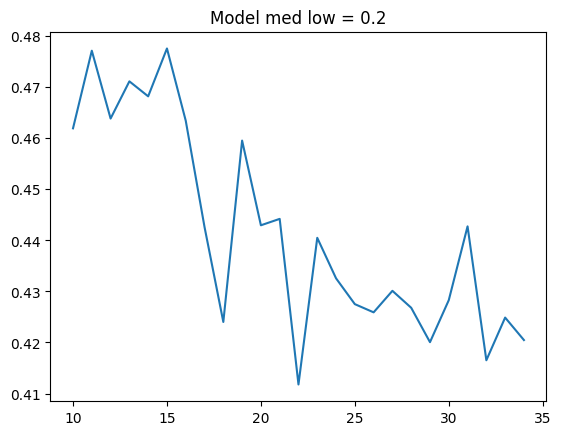

In [73]:
fig, ax = plt.subplots()
ax.plot(model_results["Topics"], model_results['Coherence'])
ax.set_title("Model med low = 0.2")
fig.savefig("plots/2000_erne/Coherence_score_05_02_2023_4")

In [74]:
coherence_best = [coherence for coherence in model_results['Coherence']]
coherence_best.sort(reverse = True)

In [75]:
for top_coherence in coherence_best[0:5]:
    number_topics = model_results["Topics"][model_results['Coherence'].index(top_coherence)]
    print(number_topics)
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=number_topics, random_state=100, 
        update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
    )
    lda_model.save(f"Modeller/2000_erne/05_02_2023_04/Model_{number_topics}_topics")

15
11
13
14
12


In [6]:
lda_model = gensim.models.ldamodel.LdaModel.load("Modeller/2000_erne/05_02_2023_04/Model_14_topics")
pprint(lda_model.print_topics(-1))

[(0,
  '0.017*"forslag" + 0.013*"give" + 0.013*"dansk" + 0.010*"problem" + '
  '0.010*"selvfølgelig" + 0.009*"gang" + 0.009*"år" + 0.009*"regering" + '
  '0.009*"mene" + 0.009*"bruge"'),
 (1,
  '0.021*"spørgsmål" + 0.016*"regel" + 0.013*"«" + 0.013*"forbindelse" + '
  '0.010*"oplyse" + 0.010*"minister" + 0.009*"person" + 0.009*"s" + '
  '0.009*"oplysning" + 0.009*"fremgå"'),
 (2,
  '0.042*"hr." + 0.027*"statsminister" + 0.027*"spørgsmål" + 0.023*"regering" '
  '+ 0.020*"eu" + 0.019*"kort_bemærkning" + 0.017*"sag" + 0.016*"spørge" + '
  '0.014*"stemme" + 0.014*"folketing"'),
 (3,
  '0.083*"s" + 0.064*"v" + 0.045*"sf" + 0.028*"medlem" + 0.027*"df" + '
  '0.026*"kf" + 0.026*"valg" + 0.021*"stedfortrædere" + 0.017*"næstformand" + '
  '0.015*"el"'),
 (4,
  '0.087*"usa" + 0.042*"fn" + 0.034*"israel" + 0.034*"ofte" + 0.033*"vente" + '
  '0.029*"amerikansk" + 0.028*"deltagelse" + 0.027*"osce" + 0.026*"dom" + '
  '0.026*"militær"'),
 (5,
  '0.077*"land" + 0.074*"dansk" + 0.061*"Danmark" + 0.031

In [7]:
lda_model.save("Modeller/Modeller_til_opgaven/Model_2000")

## Tilføjelse af nye datapunkter

In [164]:
EU_ord_ny = [" eu\.", " euro ", "euroen", " ef\.", " eu\,", " ef\,"]

In [165]:
eu_taler_00erne_mangler = {}
for år in Folketingsår_opdelt_per_taler_00erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_00erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_00erne[år][0][index]
        for ord_ in EU_ord_ny:
            if len(re.findall(ord_, tale.lower())) > 0:
                if tale not in eu_taler_00erne[år][0]:
                    eu_tale_år.append(tale)
                    eu_parti_år.append(Folketingsår_opdelt_per_taler_00erne[år][1][index])
                    eu_taler_år.append(Folketingsår_opdelt_per_taler_00erne[år][2][index])
                    break
    eu_taler_00erne_mangler[år] = []
    eu_taler_00erne_mangler[år].append(eu_tale_år)
    eu_taler_00erne_mangler[år].append(eu_parti_år)
    eu_taler_00erne_mangler[år].append(eu_taler_år)
    #slut = time()
    #print(slut-start) til at time loopsne

In [166]:
for år in eu_taler_00erne_mangler:
    print(f"{år}: {len(eu_taler_00erne_mangler[år][0])}")

2000: 501
2001: 233
2002: 269
2003: 294
2004: 323
2005: 167
2006: 256
2007: 207
2008: 326


In [144]:
tekster_klar_ny = []

In [145]:
len(tekster_klar_ny)

0

In [146]:
for år in eu_taler_00erne_mangler:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_00erne_mangler[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar_ny.append(tokens_uden_tegn)
    end = time()
    print(end-start)

26.918368101119995
14.031892776489258
16.211760759353638
14.883358240127563
18.223565101623535
9.430439949035645
13.16727614402771
10.857128143310547
17.678915977478027


In [147]:
processed_data_ny = []
for tekst in tekster_klar_ny:
    str_tekst = [str(token) for token in tekst]
    processed_data_ny.append(str_tekst)

In [148]:
bigram_ny = gensim.models.Phrases(processed_data_ny, min_count=5, threshold=100)

trigram_ny = gensim.models.Phrases(bigram_ny[processed_data_ny], threshold=100)

bigram_mod_ny = gensim.models.phrases.Phraser(bigram_ny)

trigram_mod_ny = gensim.models.phrases.Phraser(trigram_ny)

In [149]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams_ny(texts):
    return [bigram_mod_ny[doc] for doc in texts]
def create_trigrams_ny(texts):
    [trigram_mod_ny[bigram_mod_ny[doc]] for doc in texts]
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    print(end-start)
    return texts_op

In [150]:
data_wo_stopwords_ny = remove_stopwords(processed_data_ny)

data_bigrams_ny = create_bigrams_ny(data_wo_stopwords_ny)

data_lemmatized_ny = lemmatize(data_bigrams_ny, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

54.25596594810486


In [151]:
stopwords_removed_2_ny = remove_stopwords(data_lemmatized_ny) #Jeg prøver at sortere stopord fra igen

data_lemmatized_ny = stopwords_removed_2_ny

In [167]:
from random import shuffle
texts_ny = [text for text in data_lemmatized_ny]
shuffle(texts_ny)

In [168]:
gensim_dictionary = corpora.Dictionary.load("Dictionaries/2000_erne/07_11_22_flere_stopord")
gensim_corpus_ny = [gensim_dictionary.doc2bow(text) for text in texts_ny]

In [169]:
lda_model = gensim.models.ldamodel.LdaModel.load("Modeller/2000_erne/07_11_2022_flere_stopord/Model_15_topics")
pprint(lda_model.print_topics(-1))

[(0,
  '0.060*"fiskeri" + 0.032*"bilag" + 0.023*"nævn" + 0.023*"havn" + '
  '0.022*"skriftlig" + 0.020*"meddelt_mig" + 0.018*"forespørgselsdebat" + '
  '0.017*"søren_krarup" + 0.016*"fisker" + 0.015*"jensen"'),
 (1,
  '0.066*"kommune" + 0.030*"uddannelse" + 0.018*"institution" + 0.017*"andel" '
  '+ 0.015*"barn" + 0.014*"redegørelse_r" + 0.014*"amt" + 0.012*"antal" + '
  '0.012*"opgave" + 0.011*"samle"'),
 (2,
  '0.079*"tyrkiet" + 0.073*"rusland" + 0.049*"europarådet" + '
  '0.033*"tjetjenien" + 0.033*"optagelse" + 0.027*"nato" + 0.026*"bulgarien" + '
  '0.025*"rumænien" + 0.023*"medlem" + 0.023*"medlemskab"'),
 (3,
  '0.053*"statsminister" + 0.051*"forslag" + 0.050*"behandling" + 0.046*"nr." '
  '+ 0.027*"lov" + 0.024*"folketing" + 0.021*"sf" + 0.021*"fremsætte" + '
  '0.020*"medlem" + 0.020*"lovforslag"'),
 (4,
  '0.055*"spørgsmål" + 0.042*"minister" + 0.024*"svar" + 0.021*"sag" + '
  '0.020*"kommission" + 0.018*"oplyse" + 0.017*"s" + 0.014*"forbindelse" + '
  '0.012*"vurdering" + 0.

In [170]:
lda_model.update(gensim_corpus_ny)

In [171]:
len(gensim_corpus_ny)

2582

In [172]:
pprint(lda_model.print_topics(-1))

[(0,
  '0.083*"fiskeri" + 0.038*"fisker" + 0.030*"fisk" + 0.024*"meddelt_mig" + '
  '0.024*"nævn" + 0.024*"skriftlig" + 0.018*"karen_j" + 0.015*"havn" + '
  '0.015*"bjarne_laustsen" + 0.013*"investor"'),
 (1,
  '0.065*"kommune" + 0.033*"uddannelse" + 0.029*"erhvervsliv" + 0.019*"amt" + '
  '0.017*"skole" + 0.016*"valuta" + 0.016*"institution" + 0.014*"service" + '
  '0.013*"program" + 0.013*"svensk"'),
 (2,
  '0.167*"tyrkiet" + 0.062*"medlem" + 0.042*"optagelse" + 0.037*"rusland" + '
  '0.032*"rumænien" + 0.026*"tyrkisk" + 0.024*"dato" + 0.021*"ytringsfrihed" + '
  '0.020*"opfylde" + 0.018*"bulgarien"'),
 (3,
  '0.126*"statsminister" + 0.048*"forslag" + 0.032*"keld_albrechtsen" + '
  '0.023*"stemme" + 0.023*"sf" + 0.022*"fremsætte" + 0.021*"ændringsforslag" + '
  '0.021*"afstemning" + 0.021*"dagsorden" + 0.019*"behandling"'),
 (4,
  '0.098*"minister" + 0.056*"spørgsmål" + 0.044*"svar" + 0.034*"«" + 0.021*"s" '
  '+ 0.019*"kommission" + 0.016*"vurdering" + 0.015*"begrundelse" + '
  '0.0

In [ ]:
lda_model.save("Modeller/Modeller_til_opgaven")

### Undersøger disse topics:

In [220]:
år_2000erne = [str(2000+i) for i in range(9)]
år_2000erne

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008']

In [221]:
folketingsår = ["0" + str(i) + "/" + "0" + str(i + 1) for i in range(9)]
folketingsår

['00/01',
 '01/02',
 '02/03',
 '03/04',
 '04/05',
 '05/06',
 '06/07',
 '07/08',
 '08/09']

In [191]:
def topic_counter(data_lemmatized, topic_number):
    topics_subject = []
    topics_subject_sand = []
    for index in range(len(data_lemmatized)):
        bow = gensim_dictionary.doc2bow(data_lemmatized[index])
        eu_tale_topic_distribution = lda_model.get_document_topics(bow)
        for topic, sand in eu_tale_topic_distribution:
            if topic == topic_number:
                topics_subject.append(index)
                topics_subject_sand.append(sand)
    return topics_subject, topics_subject_sand

In [192]:
def year_counter(topics_subject):
    year_datapoints = [Alle_taler_år[i] for i in topics_subject]
    year_numbers = []
    for år in år_2000erne:
        year_numbers.append(year_datapoints.count(år))
    return year_numbers

(0.0, 1.1)

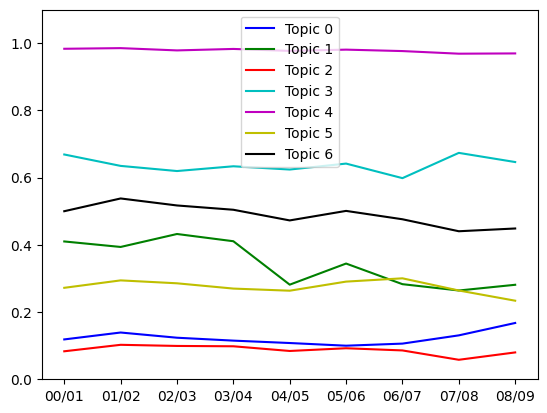

In [52]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(7):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number])
ax.legend()
ax.set_ylim([0, 1.1])

(0.0, 1.1)

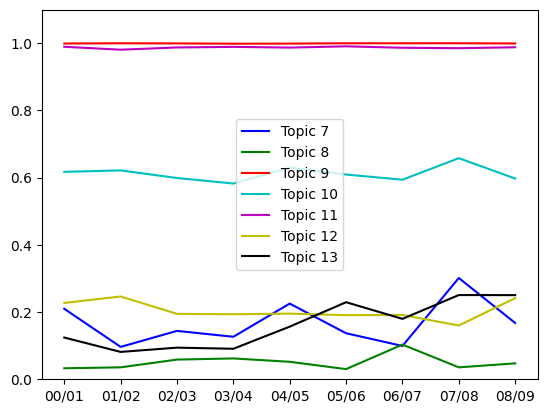

In [53]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(7,14):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1.1])

(0.0, 1.1)

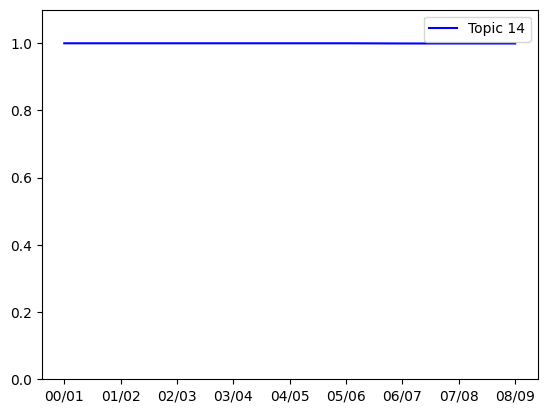

In [54]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(14,15):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1.1])

In [ ]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(21,28):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1.1])

### 0 Undersøgelse af topic 0

In [215]:
topics_fiskeri = []
topics_fiskeri_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 0:
            topics_fiskeri.append(index)
            topics_fiskeri_sand.append(sand)
len(topics_fiskeri)

2007

In [216]:
topics_fiskeri_år = [Alle_taler_år[i] for i in topics_fiskeri]
topics_fiskeri_antal_taler_00_eren = []

for år in år_2000erne:
    topics_fiskeri_antal_taler_00_eren.append(topics_fiskeri_år.count(år))
topics_fiskeri_andel = [topics_fiskeri_antal_taler_00_eren[i]/antal_taler_år[i] for i in range(9)]

In [217]:
sand_fiskeri_sort = [sand for sand in topics_fiskeri_sand]
sand_fiskeri_sort.sort(reverse = True)

In [219]:
topics_fiskeri_andel

[0.11285266457680251,
 0.09341923607915324,
 0.08863356585966352,
 0.0839135214364236,
 0.08206811653672548,
 0.11148421759570182,
 0.12828282828282828,
 0.08971774193548387,
 0.09975186104218363]

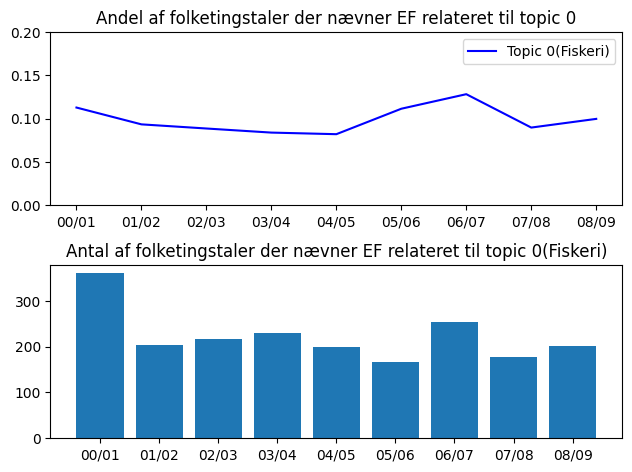

In [222]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 0")
ax1.plot(folketingsår, topics_fiskeri_andel, color = "b", label= "Topic 0(Fiskeri)")
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 0(Fiskeri)")
ax2.bar(folketingsår, topics_fiskeri_antal_taler_00_eren)
ax1.set_ylim([0, 0.2])
ax1.legend()
fig.tight_layout(pad=1.0)
#fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EU_relateret_til_topic_0")

In [223]:
best_sand = topics_fiskeri_sand.index(sand_fiskeri_sort[2])
best_sand_tale = topics_fiskeri[best_sand]
print(Alle_taler_år[best_sand_tale])
print(Alle_taler_parti[best_sand_tale])
Alle_taler[best_sand_tale]

2006
Bent Bøgsted (DF):


' Jeg går ud fra, at jeg skal tolke det på den måde, at hr. Bjarne Laustsen ikke går ind for, at MAF- fiskerne skal have en FKA. Det var bare lige for at få det på plads. Vi lytter selvfølgelig også til, hvad fiskerne ønsker, men hr. Bjarne Laustsen må jo lige have for øje, hvem det er, der er årsag til, at vi ikke bare kan give fiskerne alle de fisk, de vil have. Hr. Bjarne Laustsen er selv fortaler for EU, og det er jo EU, der sætter begrænsninger for, hvor mange fisk vi kan få. Jeg så gerne, at vi havde frit fiskeri i Danmark, men så skulle EU jo lade være med at blande sig. Men jeg vil gerne have hr. Bjarne Laustsen til at fortælle, om han siger ja eller nej til FKA. Ønsker hr. Bjarne Laustsen, at MAF-fiskerne skal have FKA, eller skal de ikke have FKA? (Kort bemærkning).'

In [224]:
best_sand_tale

15804

## Topic 1:

In [225]:
topics_kommune = []
topics_kommune_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 1:
            topics_kommune.append(index)
            topics_kommune_sand.append(sand)
len(topics_kommune)

6371

In [226]:
topics_kommune_år = [Alle_taler_år[i] for i in topics_kommune]
topics_kommune_antal_taler_00_eren = []

for år in år_2000erne:
    topics_kommune_antal_taler_00_eren.append(topics_kommune_år.count(år))
topics_kommune_andel = [topics_kommune_antal_taler_00_eren[i]/antal_taler_år[i] for i in range(9)]

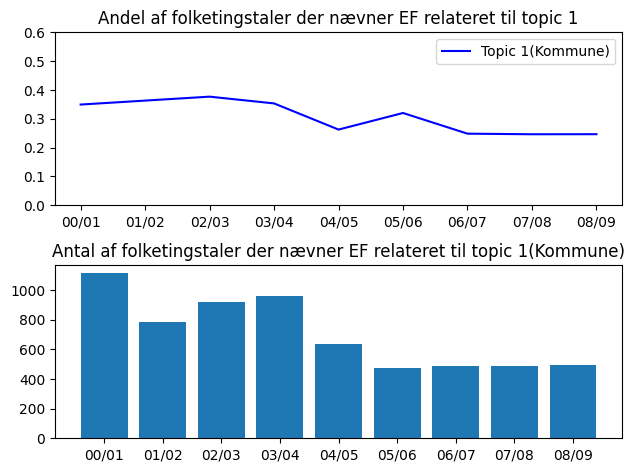

In [227]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 1")
ax1.plot(folketingsår, topics_kommune_andel, color = "b", label= "Topic 1(Kommune)")
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 1(Kommune)")
ax2.bar(folketingsår, topics_kommune_antal_taler_00_eren)
ax1.set_ylim([0, 0.6])
ax1.legend()
fig.tight_layout(pad=1.0)
#fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EU_relateret_til_topic_1")

In [228]:
sand_kommune_sort = [sand for sand in topics_kommune_sand]
sand_kommune_sort.sort(reverse = True)

In [229]:
best_sand = topics_kommune_sand.index(sand_kommune_sort[6])
best_sand_tale = topics_kommune[best_sand]
print(Alle_taler_år[best_sand_tale])
print(Alle_taler_parti[best_sand_tale])
Alle_taler[best_sand_tale]

2003
Undervisningsministeriet (note 2)


' Kvalifikationsnævnet. Nyoprettet Ja Nej - 0,1 0,1 0,1 0,1 0,1 0,1 De faglige råd for vurdering af udenlandske ud- 5 Nyoprettede Nej Nej - 0,0 0,0 0,0 0,0 0,0 0,0 dannelseskvalifikationer mv.. Grundskolerådet. Sammenlægning af Ungdoms- Dannet ved Ja Nej - - - _ _ _ skolerådet og Folkeskolerådet. sammenlæg- \\ ning af 2 enhe- der Rådet for Gymnasiale Uddannelser. Sammenlagt af Dannet ved Ja Nej - - - - - .. udvalgene for Uddannelsen til Højere Handelsek- sammenlæg- samen og for Uddannelsen til Højere Teknisk Eksa- ning af 4 enhe- men, Gymnasiemrådet og HF-rådet. " der Rådet om kortuddannedes fortsatte uddannelse. Nyoprettet Ja Nej - - 0,05 0,2 0,2 0,2 0,2 Rådet for Erhvervsrettet Voksen-og efteruddannel- Nyoprettet Ja Nej - - 0,1 0,2 0,2 0,2 0,2 se. Rådet for de Grundlæggende Erhvervsrettede Ud- Nyoprettet Ja Nej - - 0,1 0,3 0,3 0,3 0,3 dannelser. Kulturministeriet Det Arkæologiske Faglige Råd, Kulturarvsstyrel- Nyoprettet Ja Nej - 0,0 0,0 0,0 0,0 0,0 0>0 sen. Nyoprettet Uafhæn- T 1 d 

### Topic 7 om folkeafstemninger:

In [230]:
topics_folkeafstemning = []
topics_folkeafstemning_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 7:
            topics_folkeafstemning.append(index)
            topics_folkeafstemning_sand.append(sand)
len(topics_folkeafstemning)

3355

In [231]:
topics_folkeafstemning_år = [Alle_taler_år[i] for i in topics_folkeafstemning]
topics_folkeafstemning_antal_taler_2000eren = []

for år in år_2000erne:
    topics_folkeafstemning_antal_taler_2000eren.append(topics_folkeafstemning_år.count(år))
topics_folkeafstemning_andel = [topics_folkeafstemning_antal_taler_2000eren[i]/antal_taler_år[i] for i in range(9)]

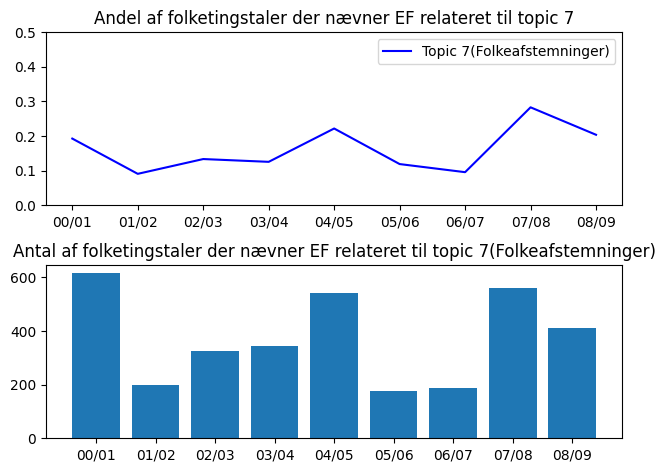

In [240]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 7")
ax1.plot(folketingsår, topics_folkeafstemning_andel, color = "b", label= "Topic 7(Folkeafstemninger)")
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 7(Folkeafstemninger)")
ax2.bar(folketingsår, topics_folkeafstemning_antal_taler_2000eren)
ax1.set_ylim([0, 0.5])
ax1.legend()
fig.tight_layout(pad=1.0)
fig.savefig("plots/Plots_opgaven/2000_erne/Andel_af_folketingstaler_der_nævner_EU_relateret_til_topic_7")

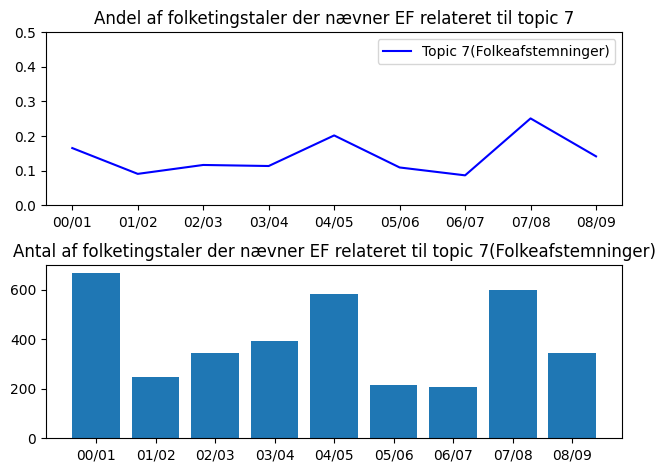

In [202]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 7")
ax1.plot(folketingsår, topics_folkeafstemning_andel, color = "b", label= "Topic 7(Folkeafstemninger)")
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 7(Folkeafstemninger)")
ax2.bar(folketingsår, topics_folkeafstemning_antal_taler_2000eren)
ax1.set_ylim([0, 0.5])
ax1.legend()
fig.tight_layout(pad=1.0)
#fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EU_relateret_til_topic_7")

In [203]:
topics_folkeafstemning_antal_taler_2000eren

[666, 247, 345, 393, 582, 216, 209, 599, 344]

### Landbrug topic 8

In [233]:
topics_landbrug = []
topics_landbrug_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 8:
            topics_landbrug.append(index)
            topics_landbrug_sand.append(sand)
len(topics_landbrug)

1039

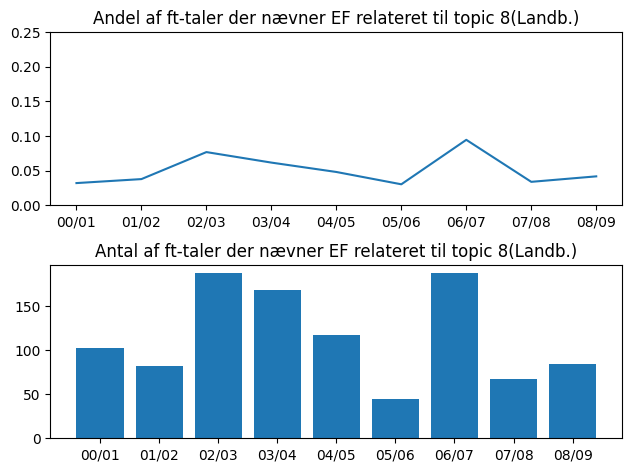

In [241]:
landbrug_taler_år = [Alle_taler_år[i] for i in topics_landbrug]
landbrug_antal_taler_2000_eren = []

for år in år_2000erne:
    landbrug_antal_taler_2000_eren.append(landbrug_taler_år.count(år))
landbrug_andel = [landbrug_antal_taler_2000_eren[i]/antal_taler_år[i] for i in range(9)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 8(Landb.)")
ax1.plot(folketingsår, landbrug_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 8(Landb.)")
ax2.bar(folketingsår, landbrug_antal_taler_2000_eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/Plots_opgaven/2000_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_8")
#ax.plot(år_1980erne, landbrug_andel)

In [206]:
topics_landbrug_2006 = [i for i in topics_landbrug if Alle_taler_år[i] == "2006"]
topics_landbrug_2006_sand = [topics_landbrug_sand[topics_landbrug.index(i)] for i in topics_landbrug if Alle_taler_år[i] == "2006"]

In [207]:
len(topics_landbrug_2006)

229

In [208]:
topics_landbrug_2006_sand_til_r = [sand for sand in topics_landbrug_2006_sand]
topics_landbrug_2006_sand_til_r.sort(reverse = True)

In [94]:
Alle_taler[topics_landbrug_2006[topics_landbrug_2006_sand.index(topics_landbrug_2006_sand_til_r[7])]]

" Nu kan jeg forstå det yderligere meget subtile, at nu inddrager vi et hvilket som helst hjørne af noget, der ville kunne kaldes landbrug! Det, vi holder os til, er landbruget; det, vi holder os til, er lovforslaget; det, vi holder os til, er begrundelserne i lovforslaget: at som led i EU's landbrugsreform er det direkte EU-tilskud til landbruget i 2005 og 2006 blevet reduceret. Det er forkert. Det var hr. Christian Wedell-Neergaard så redelig at lægge til grund for sine spørgsmål, men jeg vil sige, at indenrigsministeren benægter det i sine besvarelser. Jeg kunne virkelig unde en større del af befolkningen at læse de besvarelser. De ville føle sig hensat til et eller andet meget, meget mærkeligt. Jeg kan forstå, at hr. Jens Kirk slet ikke føler sig hensat til det, han er der bare på stedet. Landbruget har fået flere milliarder kroner ekstra, og for at nyde den forfærdelige smerte skal de have en kompensation. Det er uforståeligt for enhver anden end en, der er i landbruget."

### Topic 2 udenrigpolitik og udvidelse af EU

In [235]:
topics_UP = []
topics_UP_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 2:
            topics_UP.append(index)
            topics_UP_sand.append(sand)
len(topics_UP)

1709

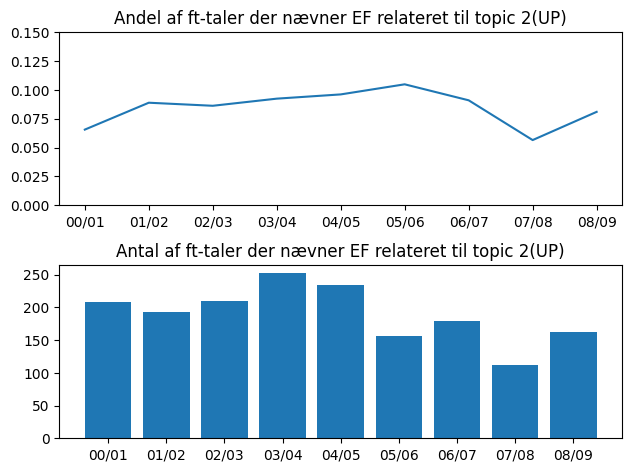

In [236]:
UP_taler_år = [Alle_taler_år[i] for i in topics_UP]
UP_antal_taler_2000_eren = []

for år in år_2000erne:
    UP_antal_taler_2000_eren.append(UP_taler_år.count(år))
UP_andel = [UP_antal_taler_2000_eren[i]/antal_taler_år[i] for i in range(9)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 2(UP)")
ax1.plot(folketingsår, UP_andel)
ax1.set_ylim([0, 0.15])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 2(UP)")
ax2.bar(folketingsår, UP_antal_taler_2000_eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_8")
#ax.plot(år_1980erne, landbrug_andel)

## Topic 13 udvidelse af om EU domstol

In [237]:
topics_domstol = []
topics_domstol_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 13:
            topics_domstol.append(index)
            topics_domstol_sand.append(sand)
len(topics_domstol)

1281

In [238]:
topics_domstol_år = [Alle_taler_år[i] for i in topics_domstol]
topics_domstol_antal_taler_2000eren = []

for år in år_2000erne:
    topics_domstol_antal_taler_2000eren.append(topics_domstol_år.count(år))
topics_domstol_andel = [topics_domstol_antal_taler_2000eren[i]/antal_taler_år[i] for i in range(9)]

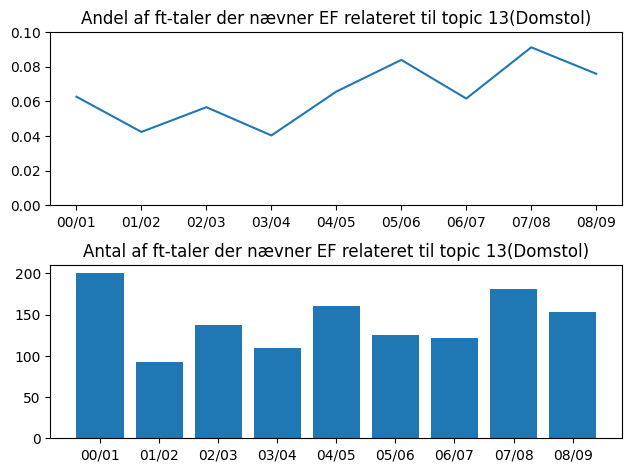

In [244]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 13(Domstol)")
ax1.plot(folketingsår, topics_domstol_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 13(Domstol)")
ax2.bar(folketingsår, topics_domstol_antal_taler_2000eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/Plots_opgaven/2000_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_13")

In [76]:
sand_domstol_sort = [sand for sand in topics_domstol_sand]
sand_domstol_sort.sort(reverse = True)

In [108]:
best_sand = topics_domstol_sand.index(sand_domstol_sort[5])
best_sand_tale = topics_domstol[best_sand]
print(best_sand_tale)
print(Alle_taler_år[best_sand_tale])
print(Alle_taler_parti[best_sand_tale])
Alle_taler[best_sand_tale]

520
2000
Knud Erik Hansen (SF):


" Jeg synes, at det helt afgørende i denne sag er, at vi snakker om rettigheder i forhold til EU's institutioner, og dér har EU en opgave i at sørge for at have orden i eget hus. Det, vi har gjort nu med det her, som jeg ser det - det er et rodet charter i forhold til mange ting, fordi der har været mange interesser inde - er rent faktisk at sige, hvad det er for nogle forpligtelser over for menneskerettighederne, vi har i EU. Dem skal vi holde orden i, men det be- tyder jo ikke, at hvis EF-Domstolen afsiger en kendelse, så kan man ikke gå til Menneskerettighedsdomstolen i Strasbourg og faktisk få underkendt EF-Domstolen. Tilsvarende hvis en dansk domstol afsiger en kendelse, og man går til Menneskerettighedsdomstolen efterfølgende, så er det da en næse til den danske domstol. Tilsvarende vil det også være for EF-domstolen, når den efterfølgende faktisk må indrette sin praksis efter det. (Kort bemærkning)."

In [99]:
for i in range(20):
    best_sand = topics_domstol_sand.index(sand_domstol_sort[i])
    best_sand_tale = topics_domstol[best_sand]
    print(best_sand_tale)

13726
312
15834
13725
15832
520
13905
13851
13854
319
12189
10442
13117
12091
12108
15019
12235
12102
12319
16376


## Miljø?

In [245]:
index_miljø = []
index_miljøminister = []
for i in range(len(Alle_taler)):
    tale = Alle_taler[i]
    if len(re.findall("miljø", tale.lower())) > 0:
        index_miljø.append(i)
        if len(re.findall("miljøminister", tale.lower())) > 0:
            index_miljøminister.append(i)

In [246]:
len(index_miljø)

3269

In [247]:
len(index_miljøminister)

664

### Miljø alene

In [276]:
index_miljø_alene = []
for i in range(len(Alle_taler)):
    tale = Alle_taler[i]
    if len(re.findall(" miljø ", tale.lower())) > 0:
        index_miljø_alene.append(i)

In [277]:
len(index_miljø_alene)

594

In [248]:
Alle_taler_miljø_minister = [Alle_taler[i] for i in index_miljøminister]

In [249]:
Alle_taler_miljø_minister[3]

' Først til fru Anni Svanholt: Ja, men jeg synes da også, det er et udmærket forslag til vedtagelse, som fru Anni Svanholt og Kristeligt Folkeparti og Enhedslisten har fremsat. Det skal der ikke herske nogen tvivl om. 1150 Torsdag den 16. november 2000 (F 16) Men det, det handler om i den sag her, er jo, at man får så bredt et mandat som muligt at drage til Haag med, for det her er altså internationale forhandlinger, og så kan man godt have alle mulige gode tanker om alverdens ting, som vi gerne støtter, og man vil også gerne være med til at præge det, men skal man virkelig nå et resultat, bliver man altså nødt til i internationale forhandlinger at udstyre en minister med et mandat, som han jo også viser sig vældig god til at udfylde. Det er sådan set svaret. Jeg har været ude for den her sammenligning også med andre forslag til vedtagelser, der er kommet fra venstrefløjen, men vi er jo et midterparti, og vi stræber efter at nå pragmatiske løsninger. Det er måske ikke så hæderfuldt, me

In [250]:
len(Alle_taler)

20434

In [252]:
3269/20434

0.15997846726044826

In [253]:
semantic_opaque = [0, 1, 3, 4, 6, 9, 11, 14]
n = 0
miljø_topics = [0 for i in range(15)]
genkendes_ikke = []
for index in index_miljø:
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    topics = [topic for topic, sand in eu_tale_topic_distribution]
    sands = [sand for topic, sand in eu_tale_topic_distribution]
    sands_sort = [sand for sand in sands]
    sands_sort.sort(reverse = True)
    for sand in sands_sort:
        topic = topics[sands.index(sand)]
        if topic not in semantic_opaque:
            miljø_topics[topic] += 1
            break
    if sum(miljø_topics) == n:
        genkendes_ikke.append(index)
    

In [254]:
miljø_topics

[0, 0, 52, 0, 0, 546, 0, 90, 177, 0, 637, 0, 1491, 59, 0]

In [255]:
sum(miljø_topics)

3052

In [74]:
len(genkendes_ikke)

192

In [108]:
data_lemmatized_miljø = [data_lemmatized[i] for i in index_miljø]

In [111]:
#building a corpus for the topic model
gensim_dictionary_miljø = corpora.Dictionary(data_lemmatized_miljø)

gensim_corpus_miljø = [gensim_dictionary.doc2bow(text) for text in data_lemmatized_miljø]

In [112]:
gensim_dictionary_miljø.save("Dictionaries/2000_erne/19_01_23_miljø")

In [113]:
def compute_coherence_values(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_miljø,
                                           id2word=gensim_dictionary_miljø,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_miljø, dictionary=gensim_dictionary_miljø, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [114]:
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results_miljø = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values(k=k)
    # Save the model results
    model_results_miljø['Topics'].append(k)
    model_results_miljø['Coherence'].append(cv)

2
3
4
5
6
7
8
9
10
11
12
13
14


## Udvidelse af EU:

In [278]:
Udvidelses_lande = ["malta", "cypern", "tjekkiet", "slovakiet", "estland", "letland", "litauen", "polen", "slovenien", "ungarn"]

In [279]:
taler_om_udvidelse_år = []
taler_om_udvidelse = []
for index in range(len(Alle_taler)):
    tale = Alle_taler[index]
    for land in Udvidelses_lande:
        if len(re.findall(land, tale.lower())) > 0:
            taler_om_udvidelse.append(tale)
            taler_om_udvidelse_år.append(Alle_taler_år[index])
            break

In [280]:
len(taler_om_udvidelse)

568

In [281]:
taler_om_udvidelse[200]

" »Vil ministeren kommentere de analyser, der er offentliggjort i Ugebrevet A4, der viser, at op mod 150.000 polakker og 70.000 estere har konkrete planer om at rejse til Danmark for at søge arbejde i løbet af de første fem år efter EU's udvidelse med disse lande er trådt i kraft, og i øvrigt give en vurdering af, hvilke konsekvenser en sådan tilgang af arbejdskraft vil få for det danske arbejdsmarked?« Begrundelse De beregninger, der er offentliggjort af Ugebrevet A4, svarer ikke til de forventninger, regeringen har givet udtryk for, idet såvel statsministeren som europaministeren flere gange - med henvisning til erfaringerne fra Spaniens, Portugals og Grækenlands optagelse i EU - har hævdet, at der kun kan forventes en meget beskeden tilstrømning af udenlandsk arbejdskraft fra de nye medlemslande. Det er vigtigt for offentligheden, at ministeren oplyser, om regeringen - nu, hvor EU-udvi- delsen er besluttet - vil fastholde, at der kun kan forventes en yderst beskeden tilstrømning af 

In [282]:
taler_om_udvidelse_år.count("2000")

112

In [283]:
taler_om_udvidelse_år.count("2001")

56

In [284]:
taler_om_udvidelse_år.count("2002")

82

In [285]:
taler_om_udvidelse_år.count("2003")

78

In [286]:
taler_om_udvidelse_år.count("2004")

59

In [287]:
taler_om_udvidelse_år.count("2005")

43

In [288]:
taler_om_udvidelse_år.count("2006")

52

In [296]:
taler_om_udvidelse_nævner_udvidelse = []
for tale in taler_om_udvidelse[0:250]:
    if len(re.findall("udvidelse", tale.lower())) > 0:
        taler_om_udvidelse_nævner_udvidelse.append(tale)
len(taler_om_udvidelse_nævner_udvidelse)

108

In [297]:
taler_om_udvidelse_nævner_medlem = []
for tale in taler_om_udvidelse[0:250]:
    if len(re.findall("medlem", tale.lower())) > 0:
        taler_om_udvidelse_nævner_udvidelse.append(tale)
len(taler_om_udvidelse_nævner_udvidelse)

230

In [290]:
taler_om_udvidelse_nævner_udvidelse[0]

" I Venstre er vi kede af afstemningsresultatet sidste torsdag; det er der ingen grund til at skjule. Vi er kede af det på Danmarks vegne, vi er kede af det, fordi vi fortsat mener, det havde været bedre for Danmark at være en del af den fælles valuta. Det havde været et bedre udgangspunkt for at sætte vores fingeraftryk for udviklingen i Europa. Så kunne vi have skabt bedre forudsætninger for, hvordan Danmark kunne være med til at præge udviklingen i hele Europa. Der skal naturligvis ikke herske den mindste tvivl oin, at Venstre respekterer nejet. Vi vil loyalt forvalte vælgernes afgørelse og føre europapolitik på baggrund af nejet. Derfor kan der ikke blive tale om at belære, endsige europæisere vælgerne. Venstre har også lært af nejet, lært, at der i befolkningen er en udbredt bekymring for, at EU udvikler sig for hurtigt og for centralistisk. Det er en bekymring, der giver anledning til éftertanke, og som vi naturligvis har skrevet os bag øret. Befolkningens valg indebærer, at al s